**Import Necessari**

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Funzioni Utilizzate**

In [28]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

#modello di deblur
def deblur_model(input_shape):
  inputs = layers.Input(shape=input_shape)

  # Encoder
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

  # Decoder
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(inputs, outputs)
  return model

#funzione per fare plotting di statistiche di loss (MSE) e Accuracy durante la fase di training
def plot_history(history):
  plt.figure(figsize=(12, 6))

  # Plotting della Loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plotting dell'Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

Questo modello è una rete neurale convoluzionale (CNN).
È stato progettato come un autoencoder convoluzionale.
Il suo scopo è quello di fare Deblur di immagini sfocate.

La struttura dell'Encoder è la seguente:
  - Conv2D con 64 filtri, kernel di dimensione (3, 3), attivazione ReLU e padding 'same'.
  - Conv2D con 64 filtri, kernel di dimensione (3, 3), attivazione ReLU e padding 'same'.

Questi strati convoluzionali formano la parte di encoding del modello, catturando caratteristiche rilevanti dall'immagine.

La struttura del Decoder è la seguente:
  - Conv2D con 64 filtri, kernel di dimensione (3, 3), attivazione ReLU e padding 'same'.
  - Conv2D con 1 filtro (output grayscale), kernel di dimensione (3, 3), attivazione sigmoide e padding 'same'.

Questi strati convoluzionali formano la parte di decoding del modello, ricostruendo l'immagine deblurred.

**Immagini di MNIST**

In [29]:
(x_train, y_train), (x_val,y_val) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_val = (x_val/255.).astype(np.float32)

#cambiare rapporto di grandezza tra train-val-test set

**Fase di Training del Modello**

La scelta degli iperparametri.

Batch Size: ho tentato batch size sia più alte che più basse. I risultati non sono mai variati molto. Ho scelto quindi una dimensione semplice e classica: 32.

Epochs: ho fatto training sia con 10 che con 20. Ho scelto l'opzioni più rapida

Learning rate: i lr che ho tentato sono 0.1, 0.01, 0.001 e 0.0001. L'opzione che si è rivelata migliore è stata lo 0.001.

Optimizer: ho sempre utilizzato solo Adam.

In [30]:
#parametri
batch_size = 32
epochs = 10
new_learning_rate = 0.001
new_optimizer = Adam(learning_rate=new_learning_rate)
steps_per_epoch=len(x_train) // batch_size

#dati di training
my_gen = generator(x_train,batch_size)
train_x,train_y = next(my_gen)

#dati di validazione
my_gen2 = generator(x_val,batch_size)
val_x,val_y = next(my_gen2)

model = deblur_model((28, 28, 1))
model.compile(optimizer=new_optimizer, loss='mse', metrics=['accuracy'])

history = model.fit(
    my_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(val_x,val_y),
    shuffle=True
)

mse_values_valid = history.history['val_loss']

mean_mse_valid = np.mean(mse_values_valid)
std_mse_valid = np.std(mse_values_valid)

print(f'\n Mean MSE (Validation): {mean_mse_valid}')
print(f'Standard Deviation MSE (Validation): {std_mse_valid}')

model.summary()

Epoch 1/10
1875/1875 [==============================] - 758s 403ms/step - loss: 0.0401 - accuracy: 0.7979 - val_loss: 0.0340 - val_accuracy: 0.7875
Epoch 2/10
1875/1875 [==============================] - 740s 394ms/step - loss: 0.0252 - accuracy: 0.8017 - val_loss: 0.0198 - val_accuracy: 0.7954
Epoch 3/10
1875/1875 [==============================] - 731s 390ms/step - loss: 0.0182 - accuracy: 0.8051 - val_loss: 0.0164 - val_accuracy: 0.7994
Epoch 4/10
1875/1875 [==============================] - 714s 381ms/step - loss: 0.0164 - accuracy: 0.8067 - val_loss: 0.0148 - val_accuracy: 0.7995
Epoch 5/10
1875/1875 [==============================] - 719s 383ms/step - loss: 0.0153 - accuracy: 0.8072 - val_loss: 0.0137 - val_accuracy: 0.7991
Epoch 6/10
1875/1875 [==============================] - 715s 382ms/step - loss: 0.0144 - accuracy: 0.8079 - val_loss: 0.0136 - val_accuracy: 0.8011
Epoch 7/10
1875/1875 [==============================] - 715s 382ms/step - loss: 0.0138 - accuracy: 0.8080 - val_

**Grafici storici di loss (mse) e accuracy in fase di training**

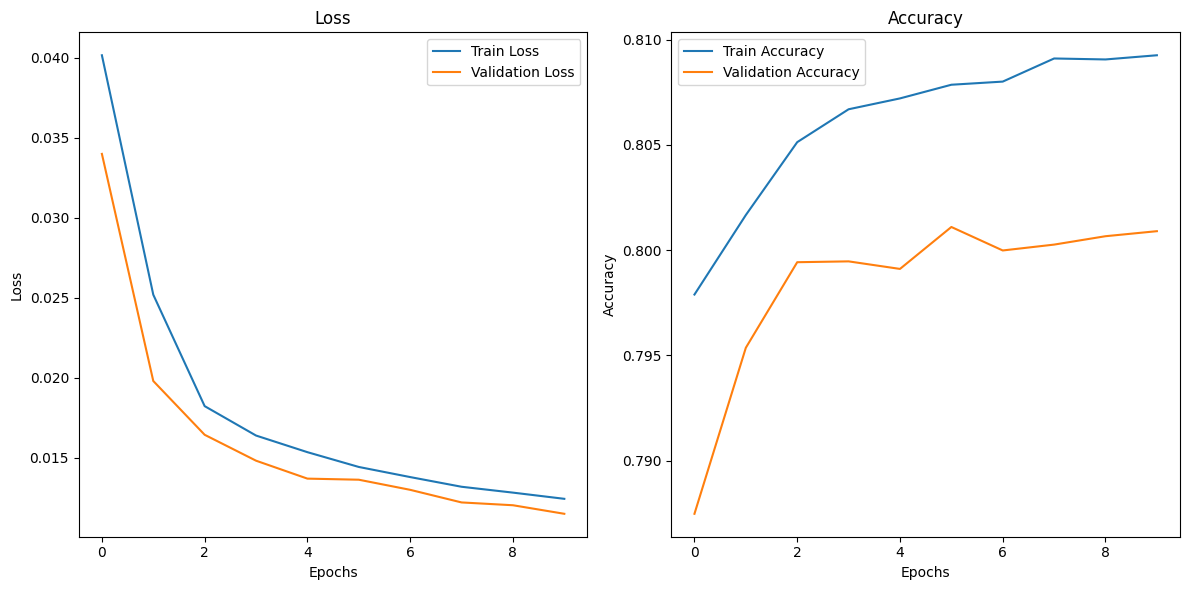

In [31]:
plot_history(history)

**Fase di Validazione del Modello**

In [33]:
(loss_value, acc_value) = model.evaluate(my_gen2, steps=len(x_val) // batch_size)

deblurred_images = model.predict(val_x, batch_size)

deblurred_images_squeezed = np.squeeze(deblurred_images)

#mse values
mse_values_valid = np.mean(np.square(deblurred_images_squeezed - val_y), axis=1)

#Calcola la deviazione standard dell'MSE
std_mse_valid = np.std(mse_values_valid)

print(f"\n MSE: {loss_value}")
print(f'\n Standard Deviation MSE: {std_mse_valid}')
print(f"\n Accuracy: {acc_value}")

1/1 [==============================] - 0s 85ms/step

 MSE: 0.012263493612408638

 Standard Deviation MSE: 0.022812968119978905

 Accuracy: 0.807204008102417


**MSE e Deviazione Standard su 10000 immagini blurred**

In [36]:
mse_list = []
num_images = 10000

for _ in range(10):
    random_indices = np.random.choice(len(x_val), num_images, replace=False)
    selected_images = x_val[random_indices]

    predictions = model.predict(selected_images)

    selected_images = selected_images.reshape(-1, 28, 28, 1)

    mse_values = tf.keras.losses.mean_squared_error(selected_images, predictions)

    mean_mse = np.mean(mse_values.numpy())
    mse_list.append(mean_mse)

mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)

print(f'MSE sul set di validazione in 10 rounds: {mean_mse}')
print(f'deviazione standard del MSE sul set di validazione in 10 rounds: {std_mse}')

313/313 [==============================] - 25s 80ms/step
MSE sul set di validazione in 10 rounds: 0.020690932869911194
deviazione standard del MSE sul set di validazione in 10 rounds: 1.4654649937995146e-08


**Immagini Blurred - Immagini Ricostruite**

32


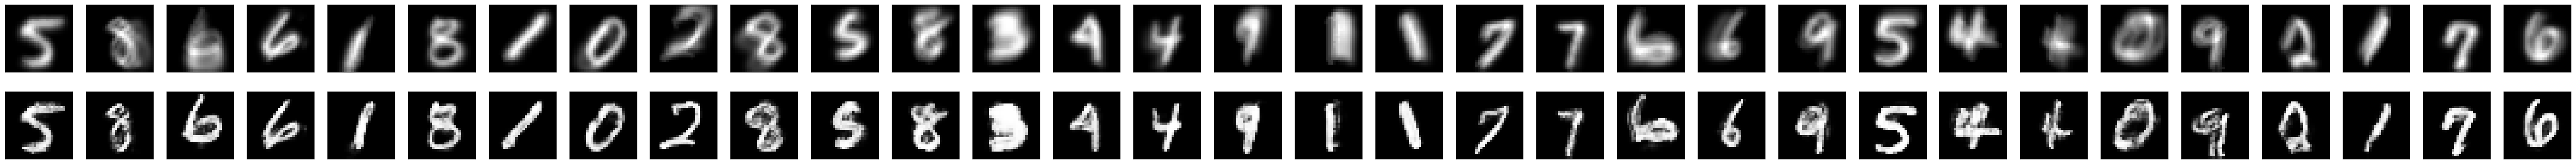

In [35]:
plot(val_x, deblurred_images)